# Segment Anything on LiDAR data


In [1]:
from segment_lidar import samlidar, view
import matplotlib.pyplot as plt
from sklearn import cluster
from math import floor
import numpy as np
import cv2 as cv

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Initialize the Segment Anything Model

- **ckpt_path:** The path to the model checkpoint.
- **model_type:** The model type to use according the checkpoint.
- **resolution:** The resolution of the LiDAR points to generate the raster.


In [19]:
viewpoint = view.TopView()
model = samlidar.SamLidar(
    ckpt_path="/mnt/Poznan_Internship/sam_vit_h_4b8939.pth",
    model_type="vit_h",
    resolution=0.15,
    sam_kwargs=True
)

## Read from a Point Cloud data file (.las, .laz)


In [20]:
points = model.read("/mnt/Poznan_Internship/Data/Campus/cloud2853085222bfe35e_Block_3.las")

Reading /mnt/Poznan_Internship/Data/Campus/cloud2853085222bfe35e_Block_3.las...
- Classification value is not provided. Reading all points...
- Reading RGB values...
File reading is completed in 4.93 seconds. The point cloud contains 29378196 points.



In [ ]:
# cloud, non_ground, ground = model.csf(points, class_threshold=0.1)

In [21]:
labels, segment_image, image = model.segment(points=points, view=viewpoint, image_path="./raster.tif", labels_path="./labeled.tif")
# model.write(points=points, non_ground=non_ground, ground=ground, segment_ids=labels, save_path="segmented.las")

- Generating raster image...
- Saving raster image...
- Applying segment-geospatial to raster image...
- Saving segmented image...
- Generating segment IDs...
Segmentation is completed in 55.19 seconds. Number of instances: 389



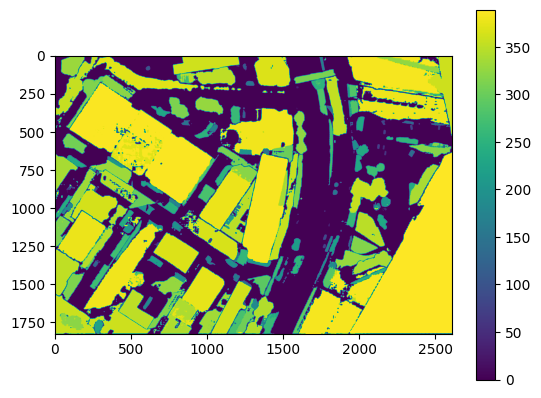

In [22]:
im = plt.imshow(segment_image)
plt.colorbar(im)

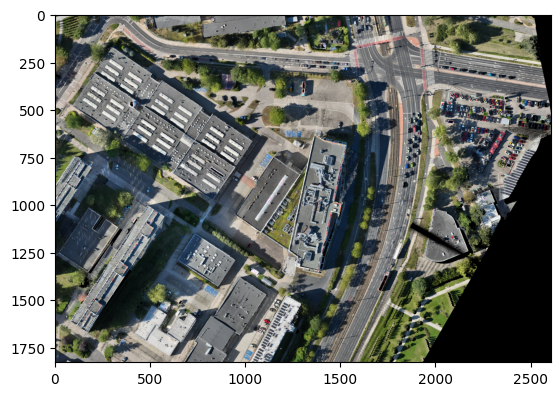

In [23]:
im = plt.imshow(image.transpose(1, 2, 0))

In [24]:
image = image.transpose((1, 2 ,0))

In [25]:
labels = np.unique(segment_image)
labels

array([  0,   2,   3,   6,   8,   9,  20,  22,  28,  32,  35,  37,  39,
        41,  43,  44,  46,  47,  48,  50,  52,  53,  55,  56,  58,  61,
        62,  63,  64,  66,  67,  68,  70,  71,  72,  73,  74,  75,  78,
        79,  80,  81,  82,  84,  85,  86,  87,  88,  90,  91,  93,  94,
        95,  98, 104, 106, 107, 110, 111, 115, 116, 117, 118, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 131, 133, 134, 136, 137, 138,
       139, 140, 143, 145, 146, 147, 148, 149, 150, 151, 152, 153, 156,
       157, 159, 161, 163, 166, 167, 168, 169, 171, 173, 174, 175, 176,
       179, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193,
       194, 196, 197, 198, 199, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 226, 227, 229, 230, 231, 232, 233, 234, 235, 236,
       237, 238, 239, 240, 241, 242, 244, 245, 246, 247, 248, 249, 250,
       251, 252, 253, 254, 256, 257, 258, 259, 261, 262, 263, 26

In [26]:
segments_img = []
filter_size = 100

for l in labels:
    if l == 0:
        continue
    mask = np.zeros(image.shape, dtype=int)
    mask[segment_image == l] = [1, 1, 1]
    result = image * mask
    seg = np.argwhere(result)
    if not seg.shape[0] or not seg.shape[1]:
        continue
    if seg.shape[0] < filter_size:
        continue

    minx, maxx = np.min(seg[:, 0]), np.max(seg[:, 0])
    miny, maxy = np.min(seg[:, 1]), np.max(seg[:, 1])
    segments_img.append(result[minx:maxx + 1, miny:maxy + 1])

# Train a clustering model to identify vegetation


In [27]:
# model = cluster.Birch(n_clusters=2)
# model = cluster.DBSCAN()
# model = cluster.SpectralClustering(2)
input_size = (32, 32)

In [28]:
def resize_image(a: np.ndarray, size: tuple, preserve_aspect_ratio: bool = True, debug: bool = False):
    assert len(a.shape) == 3, "input matrix should have a shape HxWx3"
    assert a.shape[-1] == 3, "input matrix should be a 3 channels image"

    (height, width, _) = a.shape

    (output_height, output_width) = size
    assert  output_height > 0 and output_width > 0

    aspect_ratio = 1.0
    if preserve_aspect_ratio:
        aspect_ratio = float(width) / float(height)
    
    (adjusted_height, adjusted_width) = size
    if aspect_ratio > 1.0:
        adjusted_height = int(output_height * (aspect_ratio - 1))
    elif aspect_ratio < 1.0:
        adjusted_width = int(output_width * aspect_ratio)
    
    offset_x, offset_y = floor(abs(output_width - adjusted_width) / 2), floor(abs(output_height - adjusted_height) / 2)
    assert offset_x >= 0 and offset_y >= 0, "offset_x and offset_y should be equal or greater than zero"
    
    if debug:
        print(f"Input:\theight={height} width={width} (ratio: {aspect_ratio})")
        print(f"Adj:\theight={adjusted_height} width={adjusted_width}")
        print(f"Output:\theight={output_height} width={output_width}")
        print(f"Offset:\tx={offset_x} y={offset_y}")

    result = cv.resize(a.astype('float32'), (adjusted_width, adjusted_height), interpolation=cv.INTER_NEAREST).astype(int)
    result = np.pad(result, [(offset_y, offset_y), (offset_x, offset_x), (0, 0)], mode="constant")

    # Because of round values we can get errors between 1 and -1 pixels
    if result.shape[0] != output_height:
        delta = abs(result.shape[0] - output_height)
        result = np.pad(result, [(0, delta), (0, 0), (0, 0)], mode="constant")
    if result.shape[1] != output_width:
        delta = abs(result.shape[1] - output_width)
        result = np.pad(result, [(0, 0), (0, delta), (0, 0)], mode="constant")
    
    assert result.shape[:-1] == size, "output should match expected size"
    
    return result

In [29]:
training_set = []
ok_set = []
for i in range(0, len(segments_img)):
    try:
        ok_set.append(resize_image(segments_img[i], input_size, preserve_aspect_ratio=False))
        training_set.append(ok_set[i][:, :, 1].flatten()) # Keep only the green color
    except Exception as e:
        print(f"Error for {i}: {e}")
len(training_set)

228

In [32]:
if True:
    model = cluster.MiniBatchKMeans(5)
    model.fit(training_set)

## Test clustering


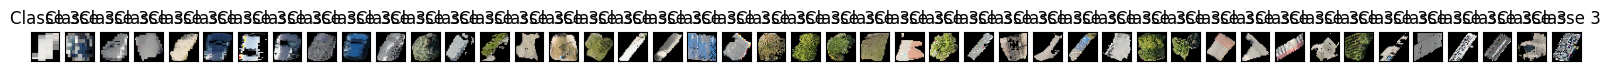

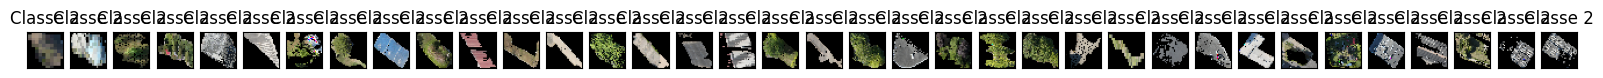

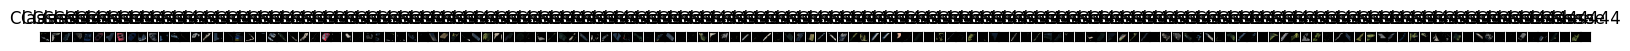

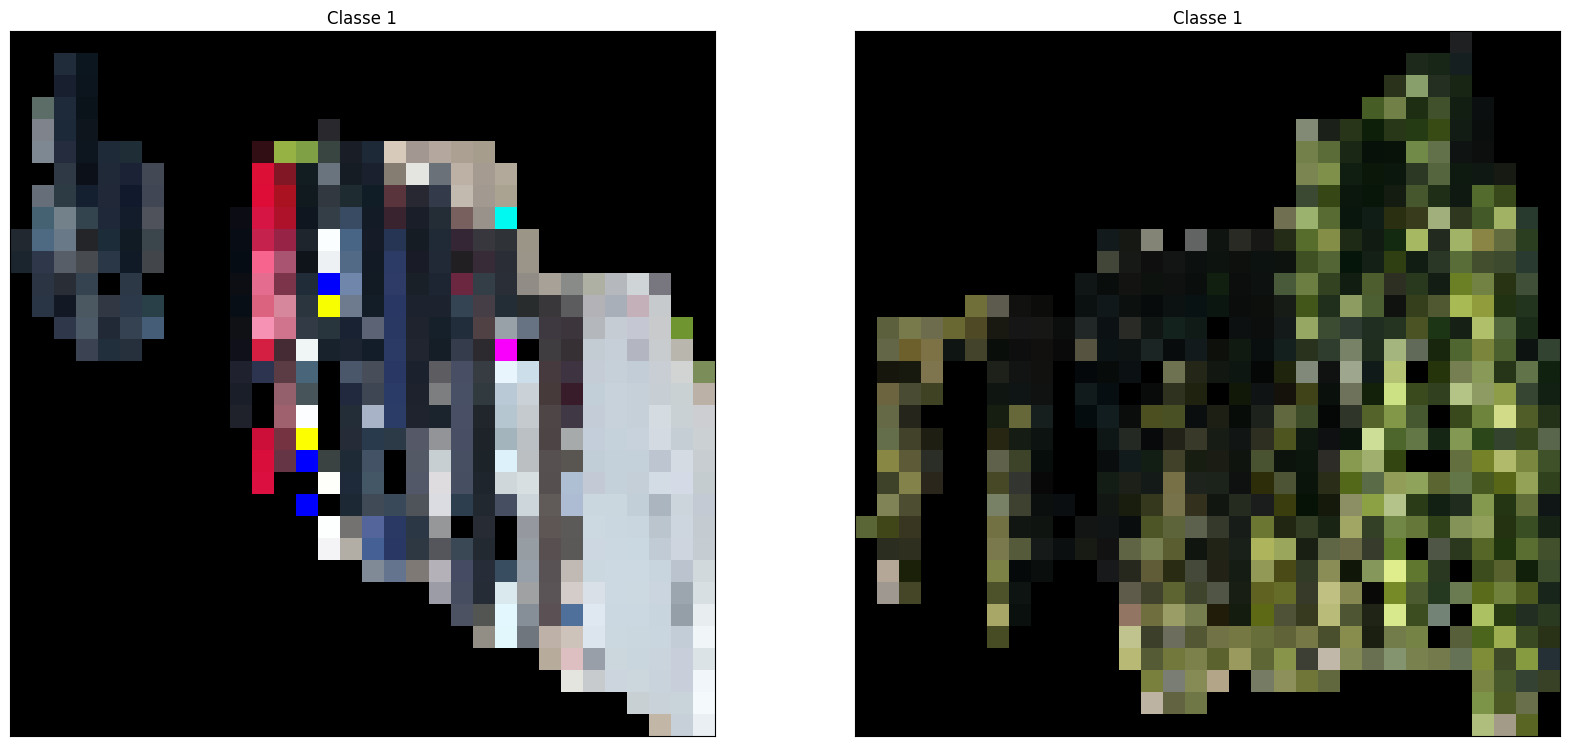

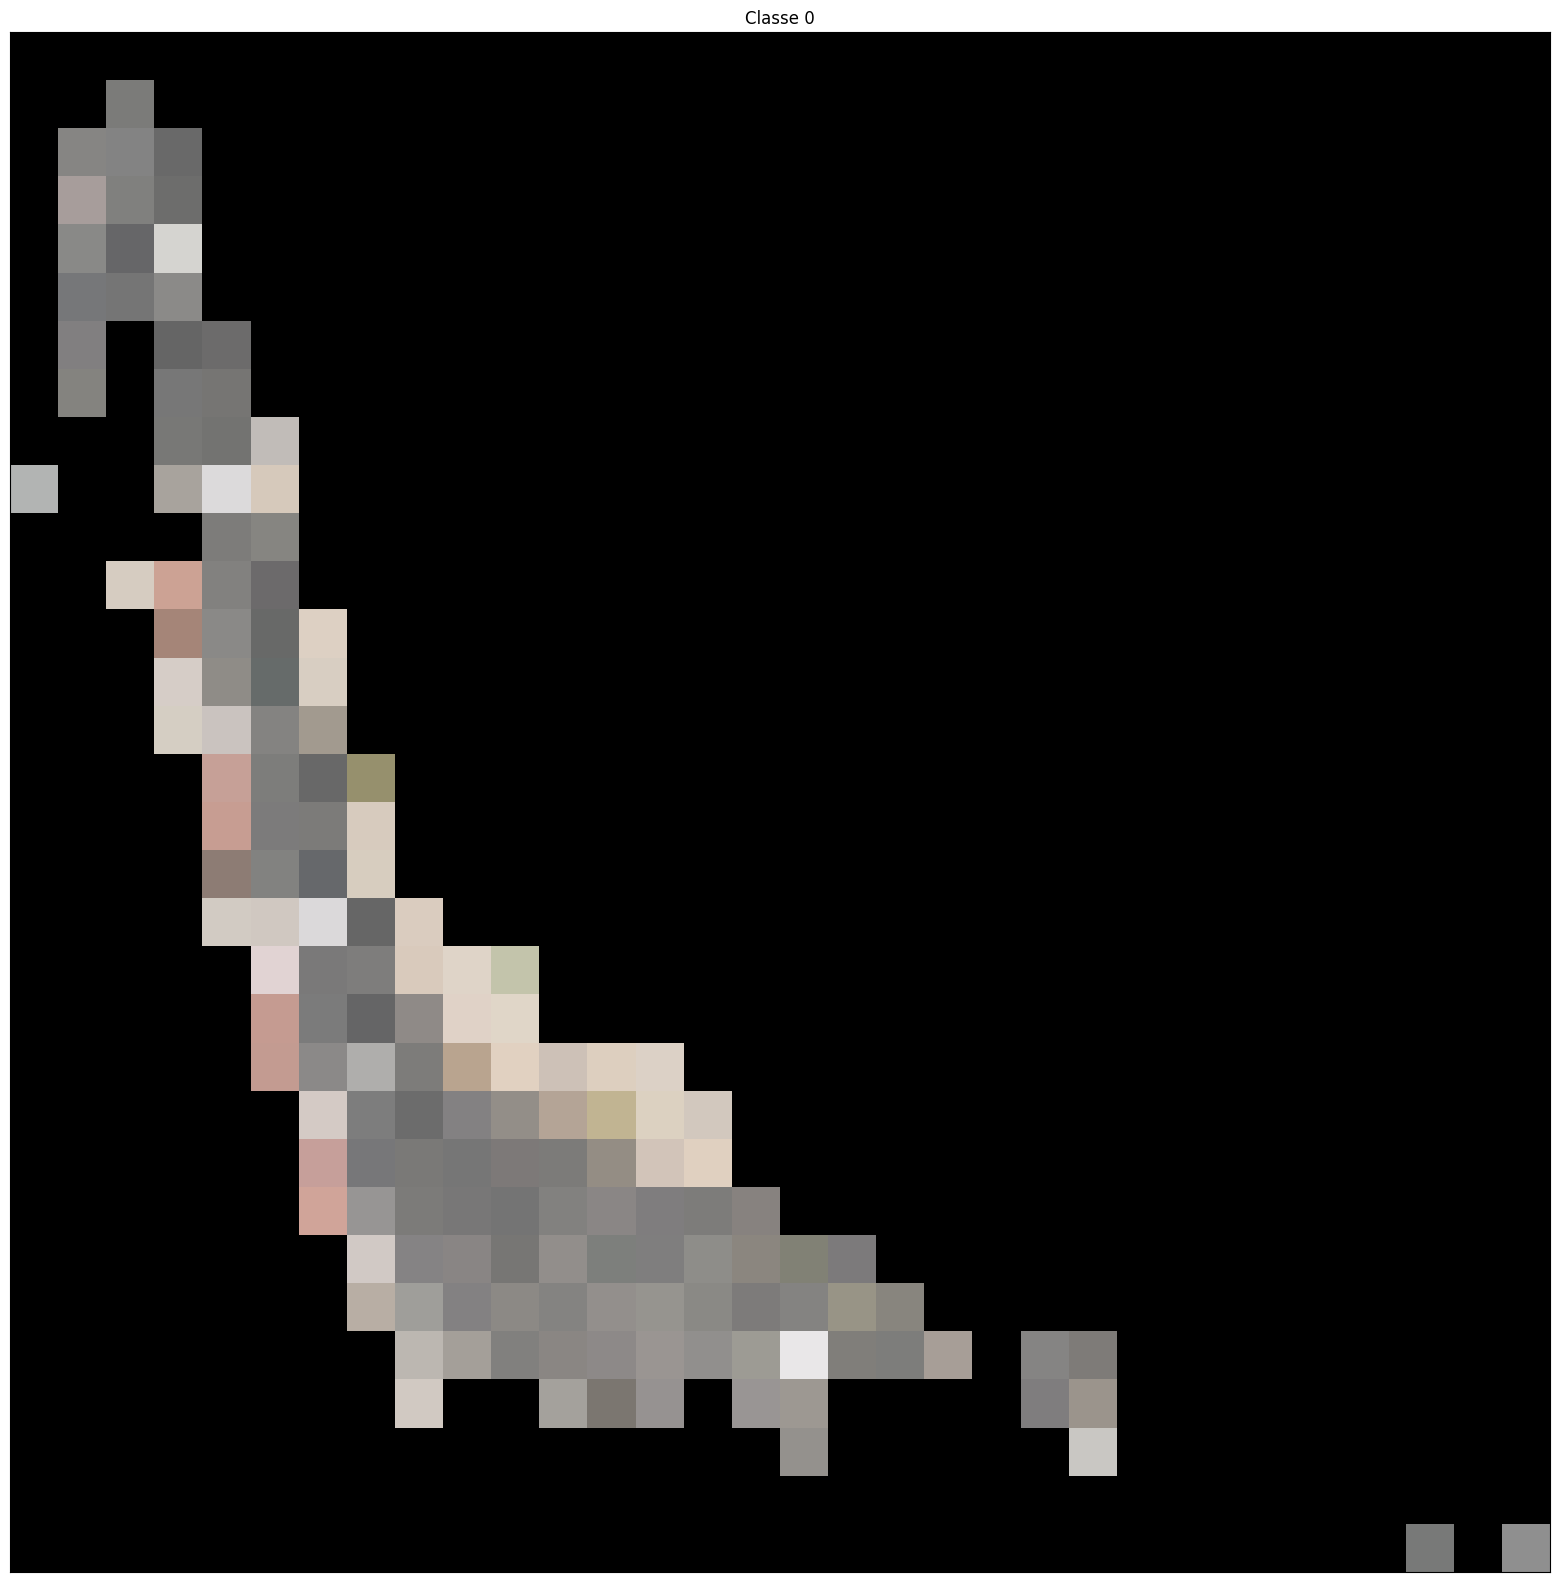

In [33]:
result = dict()
for img, c in zip(ok_set, model.fit_predict(training_set)):
    if result.get(c) is None:
        result.update({c: []})
    
    result.get(c).append(img)

for r in result:
    imgs = result.get(r)
    fig, axs = plt.subplots(1, len(imgs), figsize=(20, 20))
    for x in range(0, len(imgs)):
        if len(imgs) > 1:
            axs[x].imshow(imgs[x])
            axs[x].get_xaxis().set_visible(False)
            axs[x].get_yaxis().set_visible(False)
            axs[x].title.set_text(f'Classe {r}')
        else:
            axs.imshow(imgs[x])
            axs.get_xaxis().set_visible(False)
            axs.get_yaxis().set_visible(False)
            axs.title.set_text(f'Classe {r}')